# P300 analysis from OpenVibe/BCI2000
With lots of cool preprocessing features.
source: [https://github.com/lokinou/p300_analysis_from_openvibe](https://github.com/lokinou/p300_analysis_from_openvibe)

In [1]:
# uncomment the line wit qt below to obtain separate plots
%matplotlib inline
#%matplotlib qt


In [2]:
# if packages are missing, uncomment and execute here or in anaconda prompt with p300mne env
#!pip install "git+https://github.com/nbara/python-meegkit"
#!pip install statsmodels pyriemann

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import os
import mne
import itertools
import re
from pathlib import Path
# LDA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

## Define the analysis variables

if you don't know how to convert the .ov files, please check my [ov to gdf tutorial](https://github.com/lokinou/openvibe_to_gdf_tutorial)

In [4]:
# Directory containing the gdf files
#data_dir=r"C:\BCI\dev\p300_analysis_from_openvibe"
data_dir=r"./data_sample"
data_type= None  # bci2000 or openvibe or None for autodetection

# Define the electrodes here (for the provided sample file)
cname = None
cname = ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']
#cname = ['Fz', 'Cz', 'P3', 'Pz', 'P4', 'PO7', 'PO8', 'Oz']

# Visual
skip_slow_ERP_plot = False  # skip the channelwise ERP plot
display_preprocessing_plots = True
display_all_erp_plots = True
export_figures = True
fig_folder = './out'

# Preprocessing
apply_resample = True # in case the sampling rate is high (>=256Hz)
resample_freq = 256 # Hz
apply_infinite_reference = False  # rereferencing
apply_ASR = True  # use Artifact Subspace Reconstruction (artifact removal)
apply_CSD = False  # use Current Source Density (spatial filter)

drop_bad_epochs = False
reject_channels_full_of_artifacts = True
reject_artifactual_epochs = reject_channels_full_of_artifacts and True # do not reject epochs if you dont reject channels or use CSD
artifact_threshold = 100e-6
ratio_tolerated_artifacts = 0.3  # if 30% of artifacts in 200ms windows, then the channel is rejected

# ERP analysis parameters (values in sec)
pre_epoch = -.2
epoch_length = .6
baseline = (-.2, 0)
#isi = .0625
#flash = .125


# LDA
resample_LDA = 32 # Hz
nb_k_splits = 5



## Load the data files

In [82]:
from BCI2kReader import BCI2kReader as b2k
from BCI2kReader import FileReader as f2k

raws = []

def extract_annotations(filename, verbose=False):
    display_preprocessing_plots = False
    file= b2k.BCI2kReader(filename)

    if verbose:
        print(file.states)
    target_states = np.squeeze(file.states['StimulusType'])
    stimulus_codes = np.squeeze(file.states['StimulusCode'])
    if 'StimulusBegin' in file.states.keys():
        stimulus_begin = np.squeeze(file.states['StimulusBegin'])
    else:
        stimulus_begin = np.squeeze(file.states['Flashing'])

    phase = np.squeeze(file.states['PhaseInSequence'])

    fs = file.samplingrate

    idx_targets = np.where(target_states)[0]
    idx_codes = np.where(stimulus_codes>0)[0]
    idx_begin = np.where(stimulus_begin>0)[0]


    # In BCI2000 states are maintained over different samples, we search here the differences of when the codes are > 0
    groups = np.split(idx_codes, np.where(np.diff(idx_codes) != 1)[0]+1)
    # we take the first sample where a difference can be found
    code_change_idx = np.array([g[0] for g in groups])
    #[idx_codes[idx] for idx in code_change_idx]
    print('nb stimuli={}'.format(len(code_change_idx)))

    # we intersect the target index list with the code change to find the onset of targets and non-targets
    target_idx=np.intersect1d(code_change_idx,idx_targets)
    print('nb targets={}'.format(len(target_idx)))
    non_target_idx= np.setdiff1d(code_change_idx,idx_targets)

    # Translating into MNE Annotations 
    # define the annotations from the recovered stimuli (in seconds)
    sample_lengh = 1/fs
    onsets = code_change_idx * sample_lengh
    onsets = np.repeat(onsets, 2)  # repeat onsets
    # define the descriptio
    description_targets = np.zeros(code_change_idx.shape, dtype=np.uint)
    # index of targets in the list of stimuli onsets
    description_targets[np.searchsorted(code_change_idx, target_idx)] = 1
    description_codes = stimulus_codes[code_change_idx] + 100  # start codes at 100 because 0 and 1 are used for target and nontarget
    # merge code and target decriptions
    description = np.zeros(description_targets.shape[0]*2, dtype=np.uint)
    description[np.arange(description_targets.shape[0]*2, step=2)] = description_codes
    description[np.arange(start=1, stop=(description_targets.shape[0]*2)+1, step=2)] = description_targets

    if display_preprocessing_plots:
        fig = plt.figure()
        plt.plot(description[:100])
        fig.suptitle('Targets(1) and non-targets(0) for 100 first stimuli')

    if display_preprocessing_plots:
        fig = plt.figure()
        plt.plot(phase == 1)
        fig.suptitle('Trial begin')

    # extract trial begin markers
    new_phase_continuous = np.where(phase == 1)[0]
    groups = np.split(new_phase_continuous, np.where(np.diff(new_phase_continuous) != 1)[0]+1)
    new_trial_idx = np.array([g[0] for g in groups])
    # extract trial end markers
    new_phase_continuous = np.where(phase == 3)[0]
    groups = np.split(new_phase_continuous, np.where(np.diff(new_phase_continuous) != 1)[0]+1)
    end_of_trial_idx = np.array([g[-1] for g in groups]) # take the last index to integrate all post sequence duration

    if new_trial_idx.shape[0] > end_of_trial_idx[0]:
        print('WARNING: no end of trial for the last trial (interrupted recording?), it will be ignored for offline accuracy calculation')
        inter_trial_duration = end_of_trial_idx[0:len(new_trial_idx)] - new_trial_idx
    else:
        inter_trial_duration = end_of_trial_idx - new_trial_idx
    inter_trial_duration = inter_trial_duration * sample_lengh  # express in seconds


    print("Extracted {} trials".format(len(new_trial_idx)))

    # set a non-zero duration for stimuli (or MNE ignores them)
    duration = np.ones(onsets.shape) * sample_lengh


    # merge phase in sequence events with stimuli onsets
    onsets_phase = new_trial_idx * sample_lengh
    onsets = np.concatenate((onsets, onsets_phase))
    duration = np.concatenate((duration, inter_trial_duration))
    description = np.concatenate((description, np.ones(new_trial_idx.shape) * 10))  # concatenate trials markers=10
    srt = np.argsort(onsets) # sort according to their timing
    duration = duration[srt]
    description = description[srt]
    inter_trial_duration
    annotations = mne.Annotations(onset=onsets, duration=duration, description=description)

    file.flush()
    return annotations

def load_bci2k(filename_list):
    raws = []
    for fn in filename_list:
        cname = None
        with b2k.BCI2kReader(fn) as file:
            
            # Extract signals and states
            print('opened')
            eeg_data = file.signals
            states = file.states
            fs = file.samplingrate
            nb_chan = eeg_data.shape[0]
            #file.purge()

            # Extract channel names
            reader = f2k.bcistream(fn)
            # actualize the parameters by including the defined channel names
            if len(reader.params['ChannelNames']):
                if cname != reader.params['ChannelNames']:
                    cname = reader.params['ChannelNames']
                    print('Actualized channel names to {}'.format(cname))

            if cname is None:
                cname = [str(ch_n) for ch_n in list(range(nb_chan))]
                
            # convert states into annotations
            info = mne.create_info(cname, fs, ch_types='eeg', verbose=None)
            raw_array = mne.io.RawArray(eeg_data, info)
            # Manually force the filename or mne complains
            raw_array._filenames = [os.path.basename(fn)]
            
            annotations = extract_annotations(fn)
            raw_array.set_annotations(annotations)
            raws.append(raw_array)
    return raws

#fn = ["./data_sample/bci2000\Heide_einsteinBP_calibration4S001R01.dat"]



In [83]:
os.path.exists(data_dir)
fnames = []
for file in os.listdir(data_dir):
    if file.endswith(".gdf"):
        data_type = 'openvibe'
        fnames.append(os.path.join(data_dir, file))
        print(os.path.join(data_dir, file))
    elif file.endswith(".dat"):
        data_type = 'bci2000'
        print(os.path.join(data_dir, file))
        fnames.append(os.path.join(data_dir, file))
        
if data_type == 'openvibe':
    # load and preprocess data ####################################################
    raws = [mne.io.read_raw_gdf(f, preload=True) for f in fnames]
elif data_type == 'bci2000':
    raws = load_bci2k(fnames)
raw = mne.concatenate_raws(raws)

./data_sample\bp2calib.dat
opened


Creating RawArray with float64 data, n_channels=10, n_times=57824
    Range : 0 ... 57823 =      0.000 ...   225.871 secs
Ready.


nb stimuli=1050
nb targets=150
Extracted 5 trials


<ipython-input-82-e6d63db0218f>:134: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


In [84]:
description_targets.shape[0]

1050

In [85]:
# If the variance of the data is >1, it means the data is expressed in microvolts
# Since MNE uses Volt as a default value, we rescale microvolts to volt
if np.var(raw._data)>1:
    raw._data = raw._data * 1.e-6
    print('Rescaled signal to Volt (mean variance={})'.format(np.var(raw._data)))

Rescaled signal to Volt (mean variance=2.749515417312947e-10)


Create a name for figures output

In [86]:
output_name = Path(raw._filenames[0]).stem
if len(raw._filenames)>1:
    output_name = output_name + '_{}_files'.format(len(raw._filenames))
print('Figures will have the name: {}'.format(output_name))

Figures will have the name: bp2calib


In [87]:
if display_preprocessing_plots:
    raw.plot()

## Resample

In [88]:
if apply_resample:
    raw.resample(resample_freq)

In [89]:
montage = mne.channels.make_standard_montage('standard_1005')

if cname is None:
    cname = raw.info['ch_names']
    print('Using channel names directly from the data files: {}'.format(cname))
else:
    print('Using user defined channel names: {}'.format(cname))
        

nb_chan = len(raw.info['ch_names'])
nb_def_ch = len(cname)

# regular expressions to look for certain channel types
eog_pattern = re.compile('eog|EOG')  # EOG electrodes
emg_pattern = re.compile('emg|EMG')  # EMG electrodes
mastoid_pattern = re.compile('^[aA][0-9]+')  # A1 and A2 electrodes (mastoids)


types = []
cname_map = dict(zip(raw.info['ch_names'], cname))
for nc in cname:
    if eog_pattern.search(nc) is not None:
        t = 'eog'
    elif emg_pattern.search(nc) is not None:
        t = 'emg'
    elif mastoid_pattern.search(nc) is not None:
        t = 'misc'
    elif nc in montage.ch_names:  # check the 10-05 montage for all electrode names
        t = 'eeg'
    else:
        t = 'misc'  # if not found, discard the channel as misc
    
    types.append(t)
        
type_map = dict(zip(cname, types))

# rename and pick eeg
raw.rename_channels(cname_map, allow_duplicates=False)
raw.set_channel_types(type_map)
raw.pick_types(eeg=True, misc=False)
print('Electrode mapping')
type_map

Using user defined channel names: ['Fz', 'FC1', 'FC2', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P4', 'Oz']
Electrode mapping


{'Fz': 'eeg',
 'FC1': 'eeg',
 'FC2': 'eeg',
 'C1': 'eeg',
 'Cz': 'eeg',
 'C2': 'eeg',
 'P3': 'eeg',
 'Pz': 'eeg',
 'P4': 'eeg',
 'Oz': 'eeg'}

rename the electrodes

Set the montage

In [90]:
raw = raw.set_montage(montage, match_case=False) 

Check whether there are bad channels 

In [91]:
# Using 50Hz power variance
psd, freqs = mne.time_frequency.psd_welch(raw,verbose=True)
power_50hz = psd[:,np.where(freqs ==60)]
print('50Hz variance: {}'.format(mne.preprocessing.bads._find_outliers(power_50hz.squeeze(), threshold=3, max_iter=5, tail=0)))


# using variance
ch_var  = [np.var(raw._data[i,:]) for i in list(range(raw._data.shape[0]))]
print('Variance: {}'.format(mne.preprocessing.bads._find_outliers(ch_var, threshold=3, max_iter=5, tail=0)))

Effective window size : 1.000 (s)
50Hz variance: []
Variance: []


rereferencing

In [92]:
if apply_infinite_reference:
    raw.del_proj()  # remove our average reference projector first
    sphere = mne.make_sphere_model('auto', 'auto', raw.info)
    src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
    forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
    raw_rest = raw.copy().set_eeg_reference('REST', forward=forward)
    
    if display_preprocessing_plots:
        for title, _raw in zip(['Original', 'REST (∞)'], [raw, raw_rest]):
            fig = _raw.plot(n_channels=len(raw), scalings=dict(eeg=5e-5))
            # make room for title
            fig.subplots_adjust(top=0.9)
            fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

## Bandpass the signal
Removes noise and drift from the EEG signal by applying a infinite impulse response (two-pass) filter between .5 and 40Hz

In [93]:
raw.filter(.5, 40, fir_window='hann', method='iir')
raw.notch_filter(50)  # removes 50Hz noise
if display_preprocessing_plots:
    raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 sec)



## Excluding of channels full of artifacts (muscular or disconnecting)

Not setting metadata
Not setting metadata
2257 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2257 events and 51 original time points ...
0 bad epochs dropped
(2257, 10)


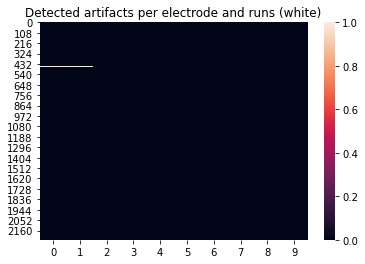

In [94]:
import seaborn as sns
#Apply a variance based channel rejection if artifacts are present >30% of the time
def detec_rej_channel(raw, duration=.2, overlap_duration=.1, threshold_eeg=artifact_threshold, reject_ratio=ratio_tolerated_artifacts):

    epochs_rej = mne.make_fixed_length_epochs(raw,duration=duration, overlap=overlap_duration, preload=True)
    epochs_rej._data.shape
    diff = np.max(epochs_rej._data, axis=2) - np.min(epochs_rej._data, axis=2)

    print(diff.shape)

    rej = (diff>=threshold_eeg).astype(np.float64)
    rel = sns.heatmap(rej)
    rel.set(title='Detected artifacts per electrode and runs (white)')

    # calculate ratio of rejected trials
    ratios = np.sum(rej,axis=0) / rej.shape[0]
    
    ret = np.argwhere(ratios >= reject_ratio).tolist()
    if len(ret)>0 and len(ret[0]):
        print('Found {} channels with at least {}% {}s epochs > {} amplitude)'.format(len(ret), 
                                                                                              reject_ratio*100, duration,
                                                                                      threshold_eeg))
        return ret[0]
    else:
        return None
    
    
if reject_channels_full_of_artifacts:
    rej_ch = detec_rej_channel(raw)
    if rej_ch is not None:
        new_bads = [raw.info['ch_names'][ch] for ch in rej_ch]
        raw.info['bads'].extend(new_bads)
        raw.pick_types(eeg=True)


## Artifact Subspace Reconstruction fitting and reconstruction

In [95]:
if apply_ASR:
    #!pip install meegkit pymanopt
    from meegkit.asr import ASR
    fs = int(raw.info["sfreq"])  # sampling frequency
    method='riemann'  # if error, use 'euclid'
    method='euclid' # pymanopt library still buggy
    window_s=.5  # .5 sec window of analysis
    data_interval_s  = None # (begin, end) in sec of the training sample
    estimator='lwf'  #leave blank if using euclidian mode 

    # define the ASR model using riemannian method
    #asr_model = ASR(sfreq=fs, method=method, win_len=window_s, estimator=estimator)

    # if failing (after trying twice. SVD error occurs for no reason sometimes)
    asr_model = ASR(sfreq=fs, method=method, win_len=window_s)

    # The best would be to choose another recording during the same session to train the model without overfitting
    data = raw._data  # the numpy array with data is stored in the _data variable

    # Select a time interval for training data
    train_idx = None
    if data_interval_s is not None:
        train_idx = np.arange(data_interval_s[0] * fs, data_interval_s[1] * fs, dtype=int)
    # otherwise select the whole training set
    else:
        train_idx = np.arange(0, data.shape[1])

    train_data = data[:, train_idx]
    print('Training on samples of size {}'.format(train_data.shape))

    # fir the ASR model with data intervals
    _, sample_mask = asr_model.fit(train_data)
    print('Model trained')


Training on samples of size (10, 57824)
Model trained


### Clean the current dataset
Please check whether using this artifact filtering method increases signal to noise ratio rather than reducing it

In [96]:
if apply_ASR:
    clean =  asr_model.transform(raw._data)

    display_window_s = 60  # 

    if display_preprocessing_plots:  #
        data_p = raw._data[0:fs*display_window_s]  # reshape to (n_chans, n_times)
        clean_p = clean[0:fs*display_window_s]

        ###############################################################################
        # Plot the results
        # -----------------------------------------------------------------------------
        #
        # Data was trained on a 40s window from 5s to 45s onwards (gray filled area).
        # The algorithm then removes portions of this data with high amplitude
        # artifacts before running the calibration (hatched area = good).
        nb_ch_disp = len(raw.info['ch_names'])
        times = np.arange(data_p.shape[-1]) / fs
        f, ax = plt.subplots(nb_ch_disp, sharex=True, figsize=(32, 16))
        for i in range(nb_ch_disp):
            # ax[i].fill_between(train_idx / fs, 0, 1, color='grey', alpha=.3,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   label='calibration window')
            # ax[i].fill_between(train_idx / fs, 0, 1, where=sample_mask.flat,
            #                   transform=ax[i].get_xaxis_transform(),
            #                   facecolor='none', hatch='...', edgecolor='k',
            #                   label='selected window')
            ax[i].plot(times, data_p[i], lw=.5, label='before ASR')
            ax[i].plot(times, clean_p[i], label='after ASR', lw=.5)
            # ax[i].plot(times, raw[i]-clean[i], label='Diff', lw=.5)
            # ax[i].set_ylim([-50, 50])
            ax[i].set_ylabel(f'ch{i}')
            ax[i].set_yticks([])
        ax[i].set_xlabel('Time (s)')
        ax[0].legend(fontsize='small', bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.subplots_adjust(hspace=0, right=0.75)
        plt.suptitle('Before/after ASR')
        plt.show()
    raw.data_ = clean

### Convert text annotations (i.e. unprocessed events) into events

**Small but major hack to realign events due to conversion**

In [97]:
if data_type=='openvibe':
    print("Erroneous annotations: {}".format(raw.annotations.description))
    print('Note here that the first annotation is 0 or 1, this is an error and thus we shift the annotations to retrieve the correct timings')
    raw.annotations.description = np.roll(raw.annotations.description, -1)
    print("Corrected annotations: {}".format(raw.annotations.description))

    # in case you want to debug the issue, I left here a way to visualize them
    # retrieving the list of annotations
    import pprint
    print(raw.annotations.to_data_frame())
    df = raw.annotations.to_data_frame()
    print('Displaying all annotations')
    annot_codes = [np.int64(n) for n in np.unique(df['description'])]
    df['description'] = df['description'].astype(int)

    if False:
        # to see and debug the fill list of annotations
        import pandas as pd
        pd.set_option('display.max_rows', None)
        #a = df[df['description'] != 33286]
        #print(a)
        print(df)
        pd.set_option('display.max_rows', 32)

### Make a list of the annotations to check whether all stimuli can be found

These annotations seem to relate to hex codes. OpenViBE definitions can be found on [OpenViBE's website](http://openvibe.inria.fr/stimulation-codes/). Let's parse the copypasted list

Make a dataframe of the stimuli in common between both

In [98]:
import pandas as pd
import re
if data_type=='openvibe':
    tr_sim= ''
    pat_extract= re.compile('^([^ ]+)[ ]+0x[0-9A-Fa-f]+[ \/]+([0-9]+)')
    #OVTK_GDF_125_Watt                                     0x585       //  1413
    k_stim = []
    k_stim_int = []
    v_stim = []

    # read and convert annotations
    with open(r'.\ov_stims.txt', 'r') as fd:
        for line in fd.readlines():
            m = pat_extract.match(line)
            v, k = m.groups()
            k_stim.append(k)
            k_stim_int.append(int(k))
            v_stim.append(v)

    # format dict and list
    stim_map = dict(zip(k_stim_int, v_stim))
    stim_map_inv = dict(zip(v_stim, k_stim))

    stim_tup = list(zip(k_stim_int, v_stim))

    df = pd.DataFrame.from_dict(stim_tup)
    df.columns = ['coden', 'desc']
    df[[c in annot_codes for c in df.coden]]

From this table, we could locate and save the codes for **Target and Non-Target** and give them the following values: target=1 and non-target=0 

In [101]:
# target = 1, nontarget = 0
target_map = None
if data_type == 'openvibe':
    target_map = {'33286':0, '33285':1}
elif data_type == "bci2000":
    target_map = {'0':0, '1':1, '10':10}

Then we can convert annotations into events

In [102]:
events, _ = mne.events_from_annotations(raw, event_id=target_map)
print("Found {} events".format(len(events[:])))

ValueError: Could not find any of the events you specified.

In [ ]:
events

### Pick the channels

In [ ]:
# pick all channels
picks = mne.pick_channels(raw.info["ch_names"], include=[])
picks
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors('3d')

## Epoching from events

Check for duplicates

In [ ]:
from collections import Counter
events[:, 0]
a = np.array(events[:, 0])
dups = [item for item, count in Counter(a).items() if count > 1]
if dups:
    print("WARNING: Duplicate found at sample(s) {}".format(dups))

In [ ]:
event_ids = dict(NonTarget=0, Target=1) 
#isi = isi
#flash = flash
pre_epoch = pre_epoch
epoch_length = epoch_length


# epoching function
epochs = mne.Epochs(raw, events, baseline=baseline, event_id=event_ids, tmin=pre_epoch, tmax=epoch_length, event_repeated='drop', picks = ['eeg', 'csd'],
                    preload=True)

# if there is any delay,
#epochs.shift_time(-isi, relative=True)
if display_preprocessing_plots:
    fig = epochs.plot()

### Making a cross correlation plot between the electrodes to see how channels relate

In [ ]:
m = np.corrcoef(raw._data)
fig = plt.figure()
hm = sns.heatmap(m,linewidths=0,cmap="YlGnBu").set(title='Cross correlation')


### Epoch rejection
Please filter out channels before epochs. A problematic channel can discard the whole recording

In [ ]:
if reject_artifactual_epochs:
    reject_criteria = dict(eeg=150e-6)  # 100 µV  #eog=200e-6)
    _ = epochs.drop_bad(reject=reject_criteria)
    if display_preprocessing_plots:
        epochs.plot_drop_log()

## Apply current source density

In [ ]:
if apply_CSD:
    epochs_csd = mne.preprocessing.compute_current_source_density(epochs)
    epochs = epochs_csd
    if display_preprocessing_plots:
        epochs_csd.plot()


### Average the epochs of each class

In [ ]:
l_nt = epochs['NonTarget'].average()
l_target = epochs['Target'].average()

target and non target signal plots

In [ ]:
if display_all_erp_plots:
    fig, ax = plt.subplots(2, 1)
    fig1 = l_target.plot(spatial_colors=True, axes=ax[0], show=False)
    fig2 = l_nt.plot(spatial_colors=True, axes=ax[1], show=False)
    # Add title
    fig.suptitle("Target(top) - Non-Target(bottom)")
    # Fix font spacing
    plt.subplots_adjust(hspace=0.5)
    plt.show()

target and non target signal topomaps

In [ ]:
if display_all_erp_plots:
    spec_kw = dict(width_ratios=[1,1,1,.15], wspace=0.5,
                   hspace=0.5,height_ratios=[1,1])
                             #hspace=0.5, height_ratios=[1, 2])

    fig, ax = plt.subplots(2, 4, gridspec_kw=spec_kw)
    l_target.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[0,:], show=False)
    l_nt.plot_topomap(times=[0, 0.18, 0.4], average=0.05, axes=ax[1,:], show=False)
    fig.suptitle("Target(top) - Non-Target(bottom)")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

joint plot (of the two former graphs). Plase not that Y scales differ between plots 

In [ ]:
l_target.plot_joint()
plt.gcf().canvas.set_window_title('Target joint plot')
l_nt.plot_joint()
plt.gcf().canvas.set_window_title('Non-Target joint plot')

Average plots

In [ ]:
if display_all_erp_plots:
    evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
                   Target=list(epochs['Target'].iter_evoked()))
    #picks = [f'eeg{n}' for n in range(10, 15)]
    mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean')

### Target vs NonTarget Erps per channel

In [ ]:
if not skip_slow_ERP_plot:
    nb_chans = epochs['Target']._data.shape[1]
    splt_width = int(np.floor(np.sqrt(1.0*nb_chans+1)))  # adding an extra plot with all channels combined at the end
    splt_height = splt_width if splt_width * splt_width >= nb_chans+1 else splt_width+1
    if splt_height * splt_width < nb_chans+1:
        splt_height += 1
    fig, ax = plt.subplots(splt_height,splt_width)

    evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
                   Target=list(epochs['Target'].iter_evoked()))
    #picks = [f'eeg{n}' for n in range(10, 15)]

    shape_epochs = epochs['Target']._data.shape
    for ch_idx in range(nb_chans):
        print('plotting channel {}'.format(ch_idx+1))
        mne.viz.plot_compare_evokeds(evokeds,picks=[epochs.info['ch_names'][ch_idx]],
                                     legend=False,
                                     axes=ax[ch_idx//splt_width, ch_idx%splt_width], show=False)
        #plt.show(block=False)
        plt.subplots_adjust(hspace=0.5, wspace=.5)
        #plt.pause(.1)
    print('plotting averaged channels')
    axs = mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine='mean',
                                 legend=True,
                                 axes=ax[-1,-1], show=False)

    plt.subplots_adjust(hspace=0.5, wspace=.5)
    plt.show()
    print("Please note that this plot is optimized for higher resolution and has the legend overlapping the average")

    if export_figures:
        out_name = os.path.join(fig_folder, output_name + '_ERPs')
        axs[0].savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')

### Display epoch at Cz and Pz

### Display single epochs

In [ ]:
if display_all_erp_plots:
    epochs['Target'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Target')
    epochs['NonTarget'].plot_image(combine='mean')
    plt.gcf().canvas.set_window_title('Non-Target')

### Same plot but channel wise

In [ ]:
if not skip_slow_ERP_plot:
    dict_electrodes = dict(eeg='EEG') if not apply_CSD else dict(csd='CSD')
    if display_all_erp_plots:
        for ch_type, title in dict_electrodes.items():
            layout = mne.channels.find_layout(epochs.info, ch_type=ch_type)
            epochs['Target'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                    font_color='k', title=title+' Target Trial x time amplitude')
            epochs['NonTarget'].plot_topo_image(layout=layout, fig_facecolor='w',
                                                    font_color='k', title=title+' Non-Target Trial x time amplitude')


# Assess ERP classificaiton accuracy

resample the signal, we don't need that much

In [ ]:
new_fs = resample_LDA #
epochs_resampled = epochs.copy().resample(new_fs)
print('resampling to {}Hz'.format(new_fs))

modify the data matrix to be properly assessed via LDA

In [ ]:
from sklearn import model_selection
X = epochs_resampled._data[:,1,:]  # input data at CZ (TODO:flatten all electrodes)
X = epochs_resampled._data[:,:,:]  # input data at CZ (TODO:flatten all electrodes)
y = epochs_resampled.events[:,2]  # ground truth

# remove the information 
    
#mne.stats.permutation_t_test()
print('Data shape from MNE {}'.format(X.shape))
X = np.moveaxis(X,1,-1)
print('new data shape with sampling prioritized over channels {}'.format(X.shape))
X = X.reshape([X.shape[0],X.shape[1]*X.shape[2]],order='C')
print('Shape for K-fold LDA {}'.format(X.shape))

# Think about splitting training sample and test samples
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

### Compute k-fold LDA

In [ ]:
clf = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
kf = KFold(n_splits=nb_k_splits)
kf.get_n_splits(X)

list_score = []
list_auc = []

for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X[train_index], X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    clf.fit(X_train_kf, y_train_kf)
    kscore = clf.score(X_test_kf,y_test_kf)
    y_pred_kf = clf.predict(X_test_kf)
    k_auc = roc_auc_score(y_test_kf, y_pred_kf)
    print('fold score: {}, AUC={}'.format(np.round(kscore, decimals=3), np.round(k_auc, decimals=3)))
    list_score.append(kscore)
    list_auc.append(k_auc)
    
print('Average score {}-Fold = {}, AUC={}'.format(kf.get_n_splits(X), np.round(np.mean(list_score), decimals=2), np.round(np.mean(list_auc), decimals=2)))

# using the training/validate samples, 
clf.fit(X_train, y_train)
score  = clf.score(X_test,y_test)
y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)

print('Score training-validation {}, AUC={}'.format(np.round(score , decimals=2), np.round(auc, decimals=2)))

print('Score is only valid if classes are balanced, please check AUC instead')

In [ ]:
nb_targets = epochs_resampled['Target'].events.shape[0]
nb_non_targets = epochs_resampled['NonTarget'].events.shape[0]

print('Data contains {}% of Non-targets'.format(np.round(100*(nb_non_targets / (epochs_resampled.events.shape[0])))))

### Display train-test LDA classification in a confusion matrix

In [ ]:

def conf_matrix(y,pred):
    cmat = metrics.confusion_matrix(y, pred)
    cmat_norm = metrics.confusion_matrix(y, pred, 
            normalize='true')
    ((tn, fp), (fn, tp)) = cmat
    ((tnr,fpr),(fnr,tpr)) = cmat_norm
    
    plt.figure()
    labels = ['Non-Target', 'Target']
    sns.heatmap(cmat, xticklabels=labels, yticklabels=labels, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.xlabel('Ground Truth')
    plt.ylabel('Predicted')
    
    # alternative using sklearn plots
    #plt.figure()
    #from sklearn.metrics import ConfusionMatrixDisplay
    #cm_display = ConfusionMatrixDisplay(cmat).plot()
    
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Non-Target)', 'True 1(Target)'], 
            columns=['Pred 0(Non-Target)', 
                            'Pred 1(Target)'])
conf_matrix(y_test,y_pred)





## Process the ROC curve and precision recall

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
y_score = clf.decision_function(X_test)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)#.plot()


# Precision Recall Display
prec, recall, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)#.plot()

# Display them side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax1.legend(loc="lower right")
pr_display.plot(ax=ax2)


if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_ROC')
    fig.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')
    
plt.show()

## Signed R-Square plot 

### Use the function from Wyrm

In [ ]:
# From https://github.com/bbci/wyrm/blob/master/wyrm/processing.py
# Bastian Venthur for wyrm
# Code initially from Benjamin Blankertz for bbci (Matlab)

def calculate_signed_r_square_mne(epochs, classes=[0,1], classaxis=0, **kwargs):
    """Calculate the signed r**2 values.
    This method calculates the signed r**2 values over the epochs of the
    ``dat``.
    Parameters
    ----------
    epochs : MNE epoched data
    classes: list, optional 
        (either int index or str for the class name of the epoch))
    classaxis : int, optional
        the dimension containing epochs
    Returns
    -------
    signed_r_square : ndarray
        the signed r**2 values, signed_r_square has one axis less than
        the ``dat`` parameter, the ``classaxis`` has been removed
    Examples
    --------
    >>> dat.data.shape
    (400, 100, 64)
    >>> r = calculate_signed_r_square(dat)
    >>> r.shape
    (100, 64)
    """
    # TODO: explain the algorithm in the docstring and add a reference
    # to a paper.
    # select class 0 and 1
    # TODO: make class 0, 1 variables
    fv1 = epochs[classes[0]]._data
    fv2 = epochs[classes[1]]._data
    # number of epochs per class
    l1 = epochs[classes[0]]._data.shape[classaxis]
    l2 = epochs[classes[1]]._data.shape[classaxis]
    # calculate r-value (Benjamin approved!)
    a = (fv1.mean(axis=classaxis) - fv2.mean(axis=classaxis)) * np.sqrt(l1 * l2)
    b = epochs._data.std(axis=classaxis) * (l1 + l2)
    r = a / b
    # return signed r**2
    return np.sign(r) * np.square(r)

rsq = calculate_signed_r_square_mne(epochs, classes=['Target','NonTarget'])

### make a pandas database to properly display electrodes and samples

In [ ]:
# make a pandas database to properly display electrodes and samples
fs = epochs.info['sfreq']
x = np.float64(list(range(rsq.shape[1])))*(1000/fs)
x = x.round(decimals=0).astype(np.int64) + np.int64(pre_epoch*1000)
df_rsq = pd.DataFrame(rsq, columns=x, index=epochs.info['ch_names'])

### Plot rsq

note that using a larger sampling rate will smooth this figure

In [ ]:
plt.figure()
hm = sns.heatmap(df_rsq,linewidths=0,cmap="coolwarm").set(title='Signed r-square maps Target vs Non-Target', xlabel='Time (ms)')

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_heatmap' )
    plt.savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')


### Quickly Display a channel with max rsq

In [ ]:
picks = None  # <- specify the channel here or it will be selected automatically
if picks is None:
    ch_max, _ = np.where(rsq == np.max(rsq))
    picks = epochs.info['ch_names'][int(ch_max)]

#picks = [f'eeg{n}' for n in range(10, 15)]
evokeds = dict(NonTarget=list(epochs['NonTarget'].iter_evoked()), 
               Target=list(epochs['Target'].iter_evoked()))
axs = mne.viz.plot_compare_evokeds(evokeds, picks=picks)  # use combine='mean' if several electrode chosen in picks

if export_figures:
    out_name = os.path.join(fig_folder, output_name + '_best_channel')
    axs[0].savefig(out_name, dpi=300, facecolor='w', edgecolor='w', bbox_inches='tight')



# Extract accuracy